# FIR filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

In [2]:
def zplane_plot(ax, z, p, k):
    """Plot pole/zero/gain plot of discrete-time, linear-time-invariant system.

    Note that the for-loop handling might be not very efficient
    for very long FIRs

    z...array of zeros in z-plane
    p...array of poles in z-zplane
    k...gain factor

    taken from own work
    URL = ('https://github.com/spatialaudio/signals-and-systems-exercises/'
           'blob/master/sig_sys_tools.py')

    currently we don't use the ax input parameter, we rather just plot
    in hope for getting an appropriate place for it from the calling function
    """
    # draw unit circle
    Nf = 2**7
    Om = np.arange(Nf) * 2*np.pi/Nf
    plt.plot(np.cos(Om), np.sin(Om), 'C7')

    try:  # TBD: check if this pole is compensated by a zero
        circle = Circle((0, 0), radius=np.max(np.abs(p)),
                        color='C7', alpha=0.15)
        plt.gcf().gca().add_artist(circle)
    except ValueError:
        print('no pole at all, ROC is whole z-plane')

    zu, zc = np.unique(z, return_counts=True)  # find and count unique zeros
    for zui, zci in zip(zu, zc):  # plot them individually
        plt.plot(np.real(zui), np.imag(zui), ms=8,
                 color='C0', marker='o', fillstyle='none')
        if zci > 1:  # if multiple zeros exist then indicate the count
            plt.text(np.real(zui), np.imag(zui), zci)

    pu, pc = np.unique(p, return_counts=True)  # find and count unique poles
    for pui, pci in zip(pu, pc):  # plot them individually
        plt.plot(np.real(pui), np.imag(pui), ms=8,
                 color='C0', marker='x')
        if pci > 1:  # if multiple poles exist then indicate the count
            plt.text(np.real(pui), np.imag(pui), pci)

    plt.text(0, +1, 'k={0:f}'.format(k))
    plt.text(0, -1, 'ROC for causal: white')
    plt.axis('square')
    plt.xlabel(r'$\Re\{z\}$')
    plt.ylabel(r'$\Im\{z\}$')
    plt.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')


def bode_plot(b, N=2**10, fig=None):  # we use this here for FIRs only
    if fig is None:
        fig = plt.figure()

    a = np.zeros(len(b))  # some scipy packages need len(a)==len(b)
    a[0] = 1

    z, p, gain = signal.tf2zpk(b, a)
    W, Hd = signal.freqz(b, a, N, whole=True)

    print('number of poles:', len(p), '\npole(s) at:', p,
          '\nnumber of zeros:', len(z), '\nzero(s) at:', z)

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C0",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C0",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p, gain)

    # impulse response
    N = 2**3  # here specially chosen for the examples below
    k = np.arange(N)
    x = np.zeros(N)
    x[0] = 1  # create a Dirac
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C0', markerfmt='C0o',
             basefmt='C0:', use_line_collection=True)
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color='C7')


def plot_windowed_FIR_design():
    hw = h*w
    W = np.arange(0, 2**10) * 2*np.pi / 2**10
    [_, H] = signal.freqz(h, a=1, worN=W)
    [_, Hw] = signal.freqz(hw, a=1, worN=W)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(k, h, 'C3o-', label='rectangular windowed FIR h[k]')
    plt.plot(k, w, 'C7o-', label='Kaiser Bessel window w[k]')
    plt.plot(k, hw, 'C0o-', label='Kaiser-Bessel windowed FIR hw[k]')
    plt.xlabel('k')
    plt.title('Impulse responses and window')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [0, 0], 'C7')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-6, -6], 'C1')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-21, -21], 'C3:')
    plt.plot([W[0]/np.pi, W[-1]/np.pi],
             [StopBandMaxLevel, StopBandMaxLevel], 'C0:')
    plt.plot([Wc/np.pi, Wc/np.pi], [StopBandMaxLevel, 0],
             'C1', label=r'-6dB @ $\Omega_c$')
    plt.plot(W/np.pi, 20*np.log10(np.abs(H)), color='C3',
             label='rectangular windowed FIR')
    plt.plot(W/np.pi, 20*np.log10(np.abs(Hw)), color='C0',
             label='Kaiser-Bessel windowed FIR')
    plt.xlim((0, 2))
    plt.yticks(np.arange(-6-12*8, 12, 12))
    plt.xlabel(r'$\Omega \,/\, \pi$')
    plt.ylabel(r'$20\lg|H(\Omega)|$ / dB')
    plt.title('Level response')
    plt.legend()
    plt.grid(True)


# some defaults for the upcoming code:
figsize = (12, 9)

# Filter Fundamentals

The transfer function of digital filters can be generally expressed in the $z$-domain as
\begin{equation}
H(z)=\frac{Y(z)}{X(z)} = \frac{\sum\limits_{m=0}^M b_mz^{-m}}{\sum\limits_{n=0}^N a_nz^{-n}}
=\frac{b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}}{a_0z^0+a_1z^{-1}+a_2z^{-2}+...+a_Nz^{-N}}
\end{equation}
with input $X(z)$ and output $Y(z)$.
Real input signals $x[k]$ that should end up as real output signals $y[k]$ (in terms of signal processing fundamentals this is a special case, though most often needed in practice) require real coefficients $b,a\in\mathbb{R}$.
This is only achieved with

- single or multiple **real** valued
- single or multiple **complex conjugate** pairs

of zeros and poles.

Furthermore, in practice we most often aim at (i) causal and (ii) bounded input, bound output (BIBO) stable LTI systems, which requires (i) $M \leq N$ and (ii) poles inside the unit circle.
If all poles **and** zeros are **inside** the unit circle then the system is **minimum-phase** and thus $H(z)$ is straightforwardly **invertible**.

Further concepts related to the transfer function are:

- Analysis of the transfer characteristics is done by the DTFT
$H(z=\mathrm{e}^{\mathrm{j}\Omega})$, i.e. evaluation on the unit circle.

- We use $a_0=1$ according to convention in many textbooks.

- The convention for arraying filter coefficients is straightforward with Python index starting at zero:
$b_0=b[0]$, $b_1=b[1]$, $b_2=b[2]$, ..., $a_0=a[0]=1$, $a_1=a[1]$, $a_2=a[2]$.

## Filtering Process

- A **non-recursive** system with $a_1,a_2,...,a_N=0$ always exhibits a **finite
impulse response** (FIR), note: $a_0=1$ for output though. Due to the finite length impulse response, a non-recursive system is always stable.

- The output signal of a **non-recursive** system in practice can be calculated by **linear
convolution** 
\begin{equation}
y[k] = \sum\limits_{m=0}^{M} h[m] x[-m+k]
\end{equation}
of the finite impulse response $h[m]=[b_0, b_1, b_2,...,b_M]$ and the input signal $x[k]$.

- A **recursive system** exhibits at least one $a_{n\geq1}\neq0$. Because
of the feedback of the output into the system, a potentially **infinite impulse
response** (IIR) and a potentially non-stable system results.

- For a **recursive** system, in practice the **difference equation**
\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M] -a_1 y[k-1] - a_2 y[k-2] - a_3 y[k-3] - ... - a_N y[k-N]
\end{equation}
needs to be implemented.

- A **pure non-recursive** system is obtained by ignoring the feedback paths, i.e. setting $a_1,a_2,...,a_N=0$.
- A **pure recursive** system is obtained by ignoring the forward paths, i.e. setting $b_0,b_1,...,b_M=0$. Then, the values of the state variables $z^{-1}, z^{-2}, ..., z^{-M}$ alone determine how the system starts to perform at $k=0$, since the system has no input actually. This system type can be used to generate (damped) oscillations.

Please note: A recursive system can have a finite impulse response, but this is very rarely the case.
Therefore, literature usually refers to
- an FIR filter when dealing with a non-recursive system
- an IIR filter when dealing with a recursive system

## Signal Flow Chart of Direct Form I

For example, the signal flow for a **second order** ($M=N=2$), system with
- a non-recursive part (feedforward paths, left $z^{-}$-path)
- a recursive part (feedback paths, left $z^{-}$-path)

is depicted below (graph taken from Wikimedia Commons) as straightforward **direct form I**, i.e. directly following the difference equation.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Biquad_filter_DF-I.svg" width=500>

Such as second order section is usually termed a biquad.

# FIR Filter

If all coefficients $a_{1,...,N}=0$, the feedback paths are not existent in the signal flow chart above.
This yields a non-recursive system and has transfer function

\begin{equation}
H(z) = \frac{Y(z)}{X(z)} = \sum\limits_{m=0}^M b_mz^{-m}
=b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}.
\end{equation}

with the difference equation 

\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M],
\end{equation}

from which we can directly observe that the impulse response (i.e. for $x[k] = \delta[k]$) is

\begin{equation}
h[k] = b_0 \delta[k] + b_1 \delta[k-1] + b_2 \delta[k-2] + ... + b_M \delta[k-M].
\end{equation}

This constitutes $h[k]$ as the coefficients $b_k$ at sample instances $k$.

The impulse response for this non-recursive system has always finite length of $M+1$ samples.

Usually this filter type is referred to as finite impulse response (FIR) filter in literature.

Very special recursive systems/filters can produce FIRs as well. This is however so rare, that
the common link FIR filter == non-recursive system is predominantly made.

The filter **order** is $M$, the **number of coefficients** $b$ is $M+1$. Be cautious here and consistent with the naming, it sometimes gets confusing. Especially for linear phase filters (see below) it is really important if $M$ or $M+1$ is either even or odd.

Sometimes the **number of taps** $M+1$ is stated (rather than calling this number of coefficients). This refers to tapping $M+1$ delayed instances of the signal input signal $x$ to calculate the filtered output signal $y$. Note however, that tapping the signal for the first coefficient $b_0$ involves non-delayed $x[k]$.

For FIR filters the magnitude at $\Omega=0$ and $\Omega=\pi$ can be straightforwardly evaluated with the following equations. 

The DC magnitude is obtained by 

\begin{align}
g_0 = \sum_{k=0}^{M} h[k].
\end{align}

The magnitude at $\Omega=\pi$ (i.e. at half the sampling frequency) is obtained by 

\begin{align}
g_\pi = \sum_{k=0}^{M} (-1)^k h[k].
\end{align}

## Poles / Zeros of FIR Filter

To calculate poles and zeros of the transfer function $H(z)$ it is meaningful to rewrite

\begin{equation}
H(z) = \sum\limits_{m=0}^M b_mz^{-m} \frac{z^M}{z^M}
=(b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}) \frac{z^M}{z^M}.
\end{equation}

This reveals that FIR filters have an $M$-fold pole at $z_\infty = 0$. This is always the case for non-recursive systems and besides the finite impulse response explains why these systems are always stable: poles in the origin are harmless, since they equally contribute to all frequencies.

For the zeros, the equation

\begin{equation}
\sum\limits_{m=0}^M b_m z^{-m} z^M = b_M z^M+b_1 z^{M-1}+b_2 z^{M-2}+...+b_M = 0
\end{equation}

needs to be solved. The $M$-th order polynomial has $M$ zeros. Recall from above, that for $b\in\mathbb{R}$ only real or complex conjugate zeros can occur, but never single complex zeros.

## Essence of FIR Filter Design

The fundamental concept (just as was it with window design for the DFT) is to place the $M$ available zeros in the $z$-plane such that a target magnitude **and** phase response results, which suits the desired filter characteristics.

It is important to note that (contrary to IIR filters) the **magnitude** and **phase** response can be **separately controlled** with FIR filters.

In the referenced [english monographs](../index.ipynb) we can find information on specific FIR design techniques such as

- FIR design with windowing method
- FIR design as minimax least-squares optimization problem
- FIR design of frequency sampling a DTFT spectrum

These are well covered in Python's Scipy and Matlab. We will later discuss the windowing method. 

## A Note on FIR Filtering vs. DFT Windowing

Consider an input signal $x[k]$.

An FIR filter $h[k]$ is used for convolution (i.e. filtering process)

\begin{align}
x[k] \ast h[k] \circ-\bullet X(\mathrm{e}^{\mathrm{j}\Omega}) \cdot H(\mathrm{e}^{\mathrm{j}\Omega}),
\end{align}

whereas the DFT windowing process involves a multiplication with a window $w[k]$

\begin{align}
x[k] \cdot w[k] \circ-\bullet \frac{1}{2\pi} X(\mathrm{e}^{\mathrm{j}\Omega}) \circledast_{2\pi} W(\mathrm{e}^{\mathrm{j}\Omega}).
\end{align}

In the DTFT domain this results in multiplication and circular convolution, respectively.

So, for the finite-length sequences $h[k]$ and $w[k]$ the same design fundamentals hold: we must put zeros at suitable locations in the z-plane to realize a certain desired DTFT spectrum, either $H(\mathrm{e}^{\mathrm{j}\Omega})$ or $W(\mathrm{e}^{\mathrm{j}\Omega})$. Depending on the application, filtering or windowing, the DTFT design criteria might be very different, since the DTFT spectrum acts as multiplication or convolution onto the input signal's DTFT spectrum. However, the design concepts and algorithms itself are basically the same, this is sometimes not so obvious in textbooks. 

# FIR Examples with M=1 and M=2

It is meaningful to discuss a very simple case of FIR in detail in the first place.
Once getting familiar with the underlying principles and concepts it is comparably easy to increase the FIR filter order and see how complexity evolves.

Almost all important issues on FIRs can be explained with

- the filter order $M=1$, thus number of coefficients is $M+1=2$ and with
- the filter order $M=2$, thus number of coefficients is $M+1=3$.

The calculus of zeros is not too tedious and can be still performed manually. Furthermore, the impact of $M$ zeros in the $z$-plain is comparably easy linked to the magnitude and phase response.

So, let's play around with some simple coefficient settings.

## Example FIR M=1, b0=1, b1=1

This is the most simple case of an FIR (actually the most simple FIR would be using only $b_0$, which is a pure gain/attenuation for input signal).

The squared magnitude response can be given analytically as (try yourself, make use of $\mathrm{e}^{-\mathrm{j}\Omega}=\cos(\Omega)-\mathrm{j}\sin(\Omega)$ ) 

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = |1 + \mathrm{e}^{-\mathrm{j}\Omega}|^2 = 2 \cos(\Omega) + 2 = 4 \cos^2(\frac{\Omega}{2}).
\end{equation}

Thus the magnitude response is 

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\cos(\frac{\Omega}{2})|,
\end{equation}

which is confirmed by the below plot (left, top). The magnitude response exhibits lowpass characteristics.

The impulse response is simply

\begin{align}
h[k] = b_0 \delta[k] + b_1\delta[k-1],
\end{align}

confirmed by the plot (right, bottom).

For the $M$-th order polynomial the $M=1$ zero is easy to evaluate

\begin{equation}
b_0 z^1+b_1 z^{0} = z+1 = 0\to z_{0,1} = -1
\end{equation}

There is $M=1$ pole in the origin, i.e. $z_{\infty,1} = 0$. Zero and pole are shown in the $z$-plane (right, top).

This FIR has special characteristics on the phase response, namely it is linear phase (type II), see discussion below.

In the present case DC magnitude is $g_0=2$ and $f_s/2$-magnitude is $g_\pi=0$.

number of poles: 1 
pole(s) at: [0.] 
number of zeros: 1 
zero(s) at: [-1.]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


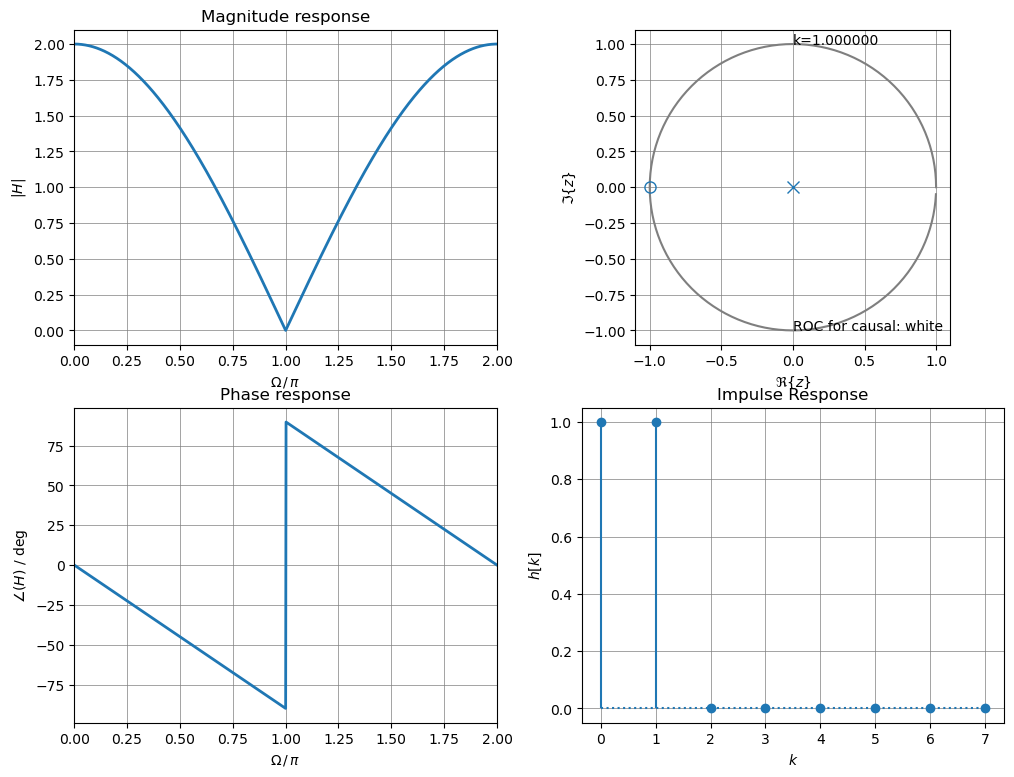

In [3]:
b = [1, 1]  # linear phase FIR Type II
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=1, b0=1, b1=-1

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \sin^2(\frac{\Omega}{2}).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\sin(\frac{\Omega}{2})|.
\end{equation}

$z_{\infty,1}=0$,
$z_{0,1}=1$

$g_0=0$,
$g_\pi=2$

Linear phase type IV

This is a simple **highpass**, it performs the difference between two adjacent samples (see the impulse response).

number of poles: 1 
pole(s) at: [0.] 
number of zeros: 1 
zero(s) at: [1.]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


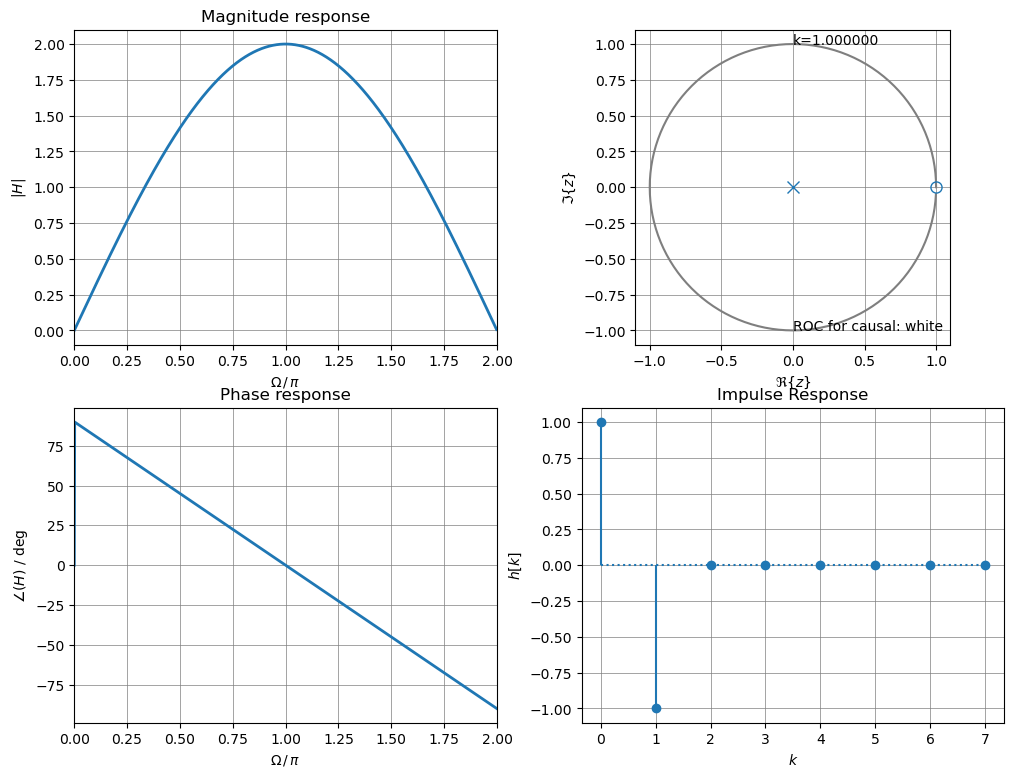

In [4]:
b = [1, -1]  # linear phase FIR Type IV
bode_plot(b, fig=plt.figure(figsize=figsize))

# Variant 2
## Example FIR M=2, b0=1, b1=1, b2=2

Filter order $M=2$, number of coefficients $M+1=3$, although one coefficient is zero, namely $b_1=0$.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \cos^2(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\cos(\Omega)|.
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=\pm \mathrm{j}$

$g_0=2$,
$g_\pi=2$

Linear phase type I

This is a simple **bandstop**.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [-0.5+1.32287566j -0.5-1.32287566j]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


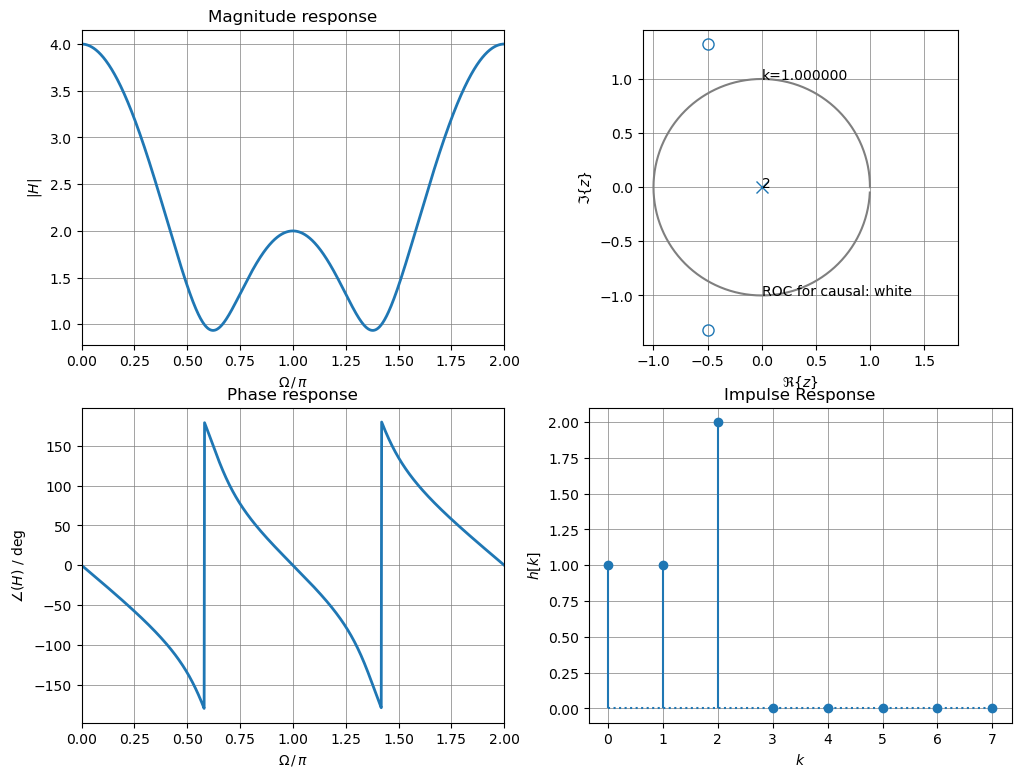

In [5]:
b = [1, 1, 2]  # linear phase FIR Type I, the zero in between counts as coeff
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=2, b0=1, b1=0, b2=-1

Filter order $M=2$, number of coefficients $M+1=3$, although one coefficient is zero, namely $b_1=0$.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \sin^2(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\sin(\Omega)|.
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

two single real zeros $z_{0,1,2}=\pm 1$

$g_0=0$,
$g_\pi=0$

Linear phase type III

This is a simple **bandpass**.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [ 1. -1.]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


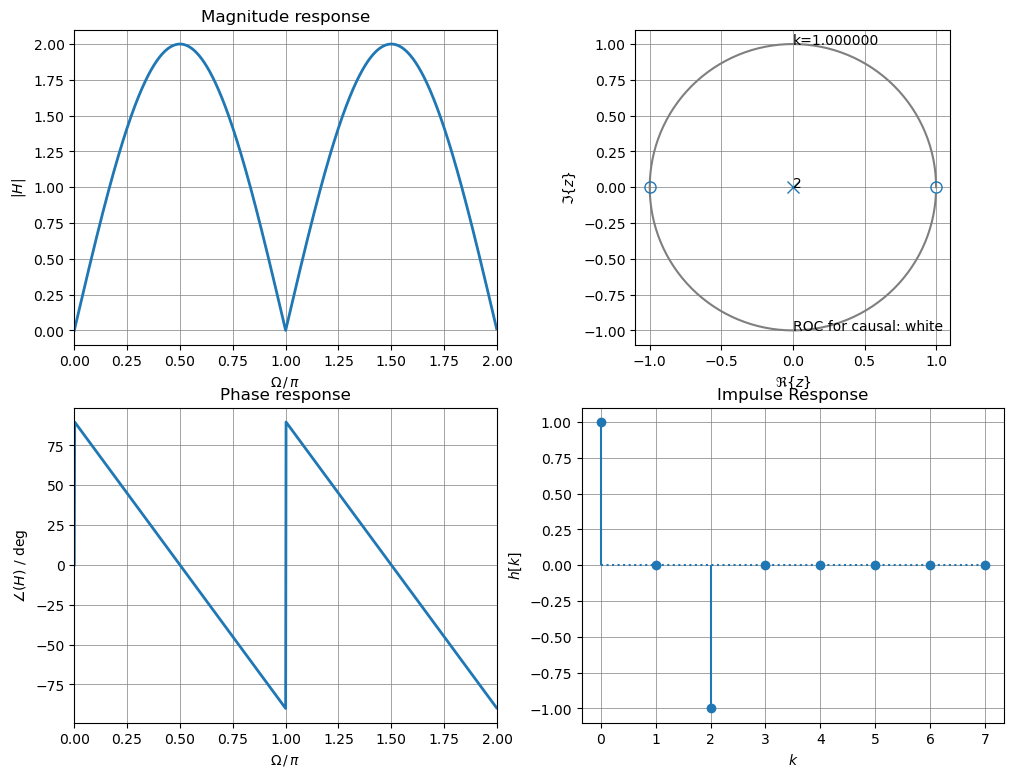

In [6]:
b = [1, 0, -1]  # linear phase FIR Type III, the zero in between counts as coeff
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=2, b0=1, b1=2, b2=1

Filter order $M=2$, number of coefficients $M+1=3$.

The manual derivation of analytic magnitude response starts to get tedious, however:

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 16 \cos^4(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 4 \cos^2(\Omega).
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

double real zero $z_{0,1,2}=-1$

$g_0=4$,
$g_\pi=0$

Linear phase type I

This is a simple **lowpass**, with a little smoother characteristics.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [-1. -1.]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


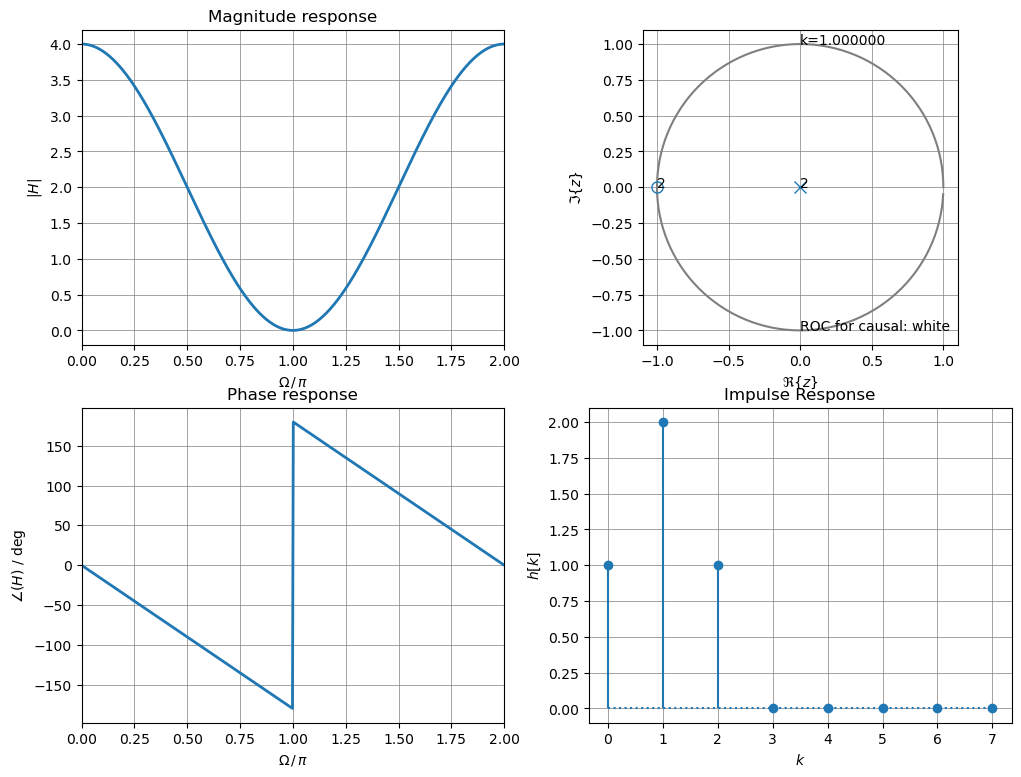

In [7]:
b = [1, 2, 1]  # linear phase FIR Type I
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=2, b0=1, b1=-2, b2=1

By reversing the sign for $b_1$ compared to the just discussed lowpass we obtain a highpass.

Filter order $M=2$, number of coefficients $M+1=3$.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 16 \sin^4(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 4 \sin^2(\Omega).
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

double real zero $z_{0,1,2}=0$

$g_0=0$,
$g_\pi=4$

Linear phase type I

This **highpass** has also slightly smoother characteristics.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [1. 1.]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


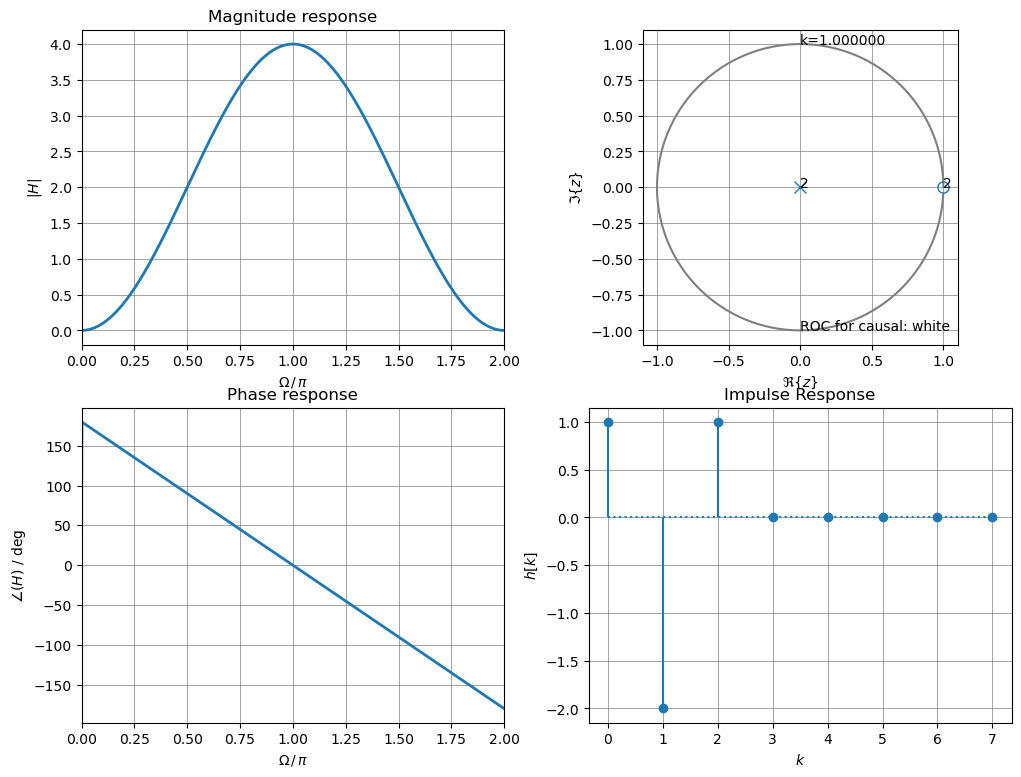

In [8]:
b = [1, -2, 1]  # linear phase FIR Type I
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=2, b0=1, b1=1, b2=1/2

So, far all zeros were aligned **on** the unit circle. We are not restricted to those locations, as long as we ensure positioning only real and complex-conjugate pairs in the $z$-plane.

However, recall that we discussed so called optimum window design for DFT-based spectral analysis.
There, zeros **on** the unit circle was a good idea, since the zero has most impact to shape the amplitude of the sidelobes. If a window has all zeros on the unit circle, we called this **optimum window**.

Back to our FIR design example:

Filter order $M=2$, number of coefficients $M+1=3$.

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=-\frac{1}{2}\pm \frac{1}{2}\mathrm{j}$

$g_0=\frac{5}{2}$,
$g_\pi=\frac{1}{2}$

This 2nd order FIR **lowpass** becomes a little more complicated and has a ripple in the stopband. Most important, since the zeros are **not** on the unit circle the magnitude response exhibits **no** exact zeros. Second morst important: the impulse response does not have a symmetry of linear-phase filter types I-IV, thus it is a **non-linear-phase** FIR. In fact, since poles and zeros are all within unit circle, the filter is minimum-phase.

Try to find and plot the inverse transfer function $H(z)^{-1}$. Why this must be a minimum phase filter as well and why is this an IIR filter. The code in Jupyter notebook `iir_filter.ipynb` might be helpful.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [-0.5+0.5j -0.5-0.5j]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


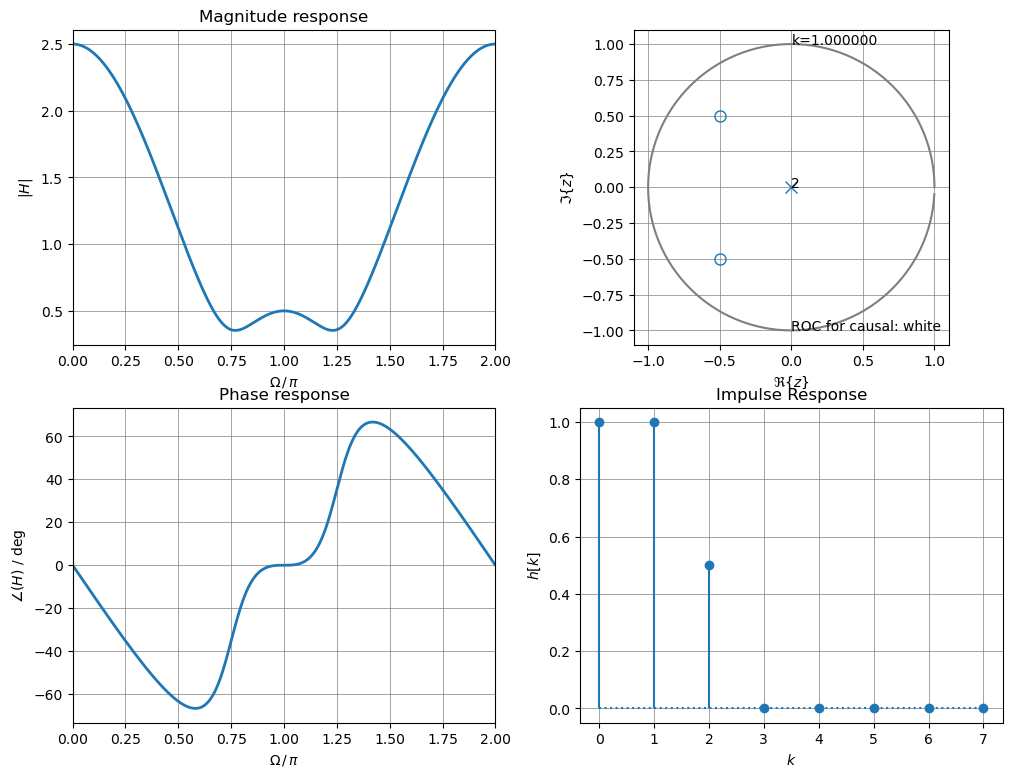

In [9]:
b = [1, 1, 1/2]  # NON linear phase FIR, since there is no symmetry in the IR
# minimum phase since all poles and zeros are inside unit circle
# this system has a stable inverse (pole/zero reversal, 1/gain factor)
bode_plot(b, fig=plt.figure(figsize=figsize))

## Example FIR M=2, b0=1/2, b1=1, b2=1

We can even align zeros outside the unit circle, since contrary to poles this has no impact on stability.

Filter order $M=2$, number of coefficients $M+1=3$.

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=-1\pm \mathrm{j}$

$g_0=\frac{5}{2}$,
$g_\pi=\frac{1}{2}$

This 2nd order FIR **lowpass** has the same magnitude response as the above lowpass. This is due to the fact that in both cases their zeros have same distance to the unit circle.

Obviously, this filter is also non-linear-phase, but also **not minimum-phase**. In fact, the filter is **maximum-phase**, i.e. the largest phase excess for the given magnitude response. Due to its maximum-phase, this FIR cannot simply be inverted, since then poles would lie outside the unit circle, yielding a non-stable system.

number of poles: 2 
pole(s) at: [0. 0.] 
number of zeros: 2 
zero(s) at: [-1.+1.j -1.-1.j]


C:\Users\student\AppData\Local\Temp\ipykernel_12684\2155594426.py:104: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax4.stem(k, h, linefmt='C0', markerfmt='C0o',


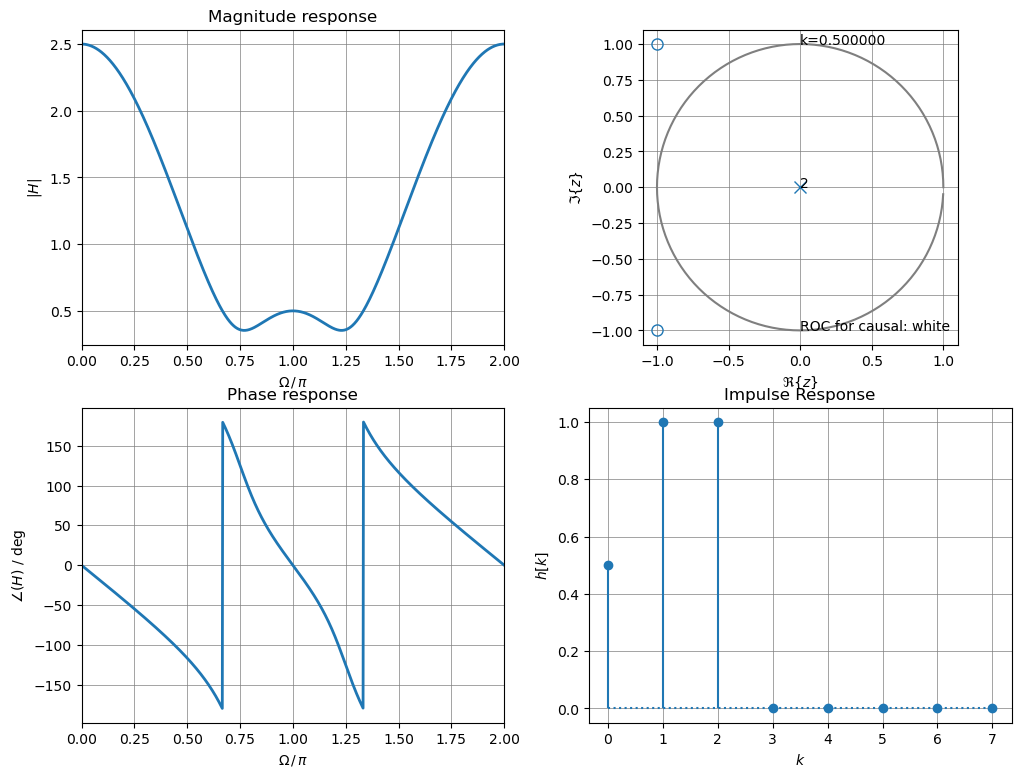

In [10]:
b = [0.5, 1, 1]  # NON linear phase FIR, since there is no symmetry in the IR
# same magnitude as b = [1, 1, 1/2]
# but also NON minimum phase since zeros outside unit-circle
# rather maximum-phase
# this system has NO stable inverse
bode_plot(b, fig=plt.figure(figsize=figsize))